## Dataset

In [1]:
import os
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as func
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm_notebook
import warnings
import IPython.display as ipd
import museval as eval4
import mir_eval.separation as eval3
from time import sleep

warnings.simplefilter(action='ignore', category=Warning)

model_path = 'MagSpectrogram_model'
model_name = 'dense_att'

musdb_train_path = 'data/musdb18/preprocessed/train/'
musdb_valid_path = 'data/musdb18/preprocessed/valid/'
musdb_test_path = 'data/musdb18/preprocessed/test/'

dsd_train_path = 'data/DSD100/preprocessed/train/'
dsd_valid_path = 'data/DSD100/preprocessed/valid/'
dsd_test_path = 'data/DSD100/preprocessed/test/'

mix_name = 'linear_mixture'
target_name = 'vocals'

dim_c = 2
dim_f = 2**10
dim_t = 2**6
n_fft=2*(dim_f-1)
hop_factor = 2
hop_length=n_fft//hop_factor
sampling_rate = 44100
sampling_size = hop_length * (dim_t+hop_factor-1)
trim = 5000  # trim each generated sub-signal (noise due to conv zero-padding)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_specs(signal):
    m, p = [], []
    for channel in signal:
        spectrogram = librosa.stft(np.array(channel, dtype=np.float32), n_fft=n_fft, center=False, hop_length=hop_length)
        m.append(np.abs(spectrogram))
        p.append(np.angle(spectrogram))
    return np.array(m), np.array(p)

def restore(m, p):
    ft = m * np.exp(1.j*p)
    channels = []
    for ft_c in ft:
        channels.append(librosa.istft(ft_c, center=False, hop_length=hop_length))
    return np.array(channels)

def load(path, s=0.0, d=None):
    return librosa.load(path, sr=None, mono=False, offset=s, duration=d)[0]


class BssDataset(Dataset):
    def __init__(self, file_path, augment=False):
        self.file_path = file_path
        self.mix_path = file_path+mix_name
        self.target_path = file_path+target_name
        self.augment = augment
        self.lengths = np.load(file_path+'lengths.npy')
    
    def __len__(self):
        return len(self.lengths)
    
    def __getitem__(self, index):
        def coin_toss():
            return np.random.rand() < 0.5 
        
        d = (sampling_size+1) / sampling_rate
        s = np.random.randint(self.lengths[index] - sampling_size - 10) / sampling_rate
        
        mix = load('{0}/{1:02}.wav'.format(self.mix_path, index), s=s, d=d)[:,:sampling_size]
        
        target = load('{0}/{1:02}.wav'.format(self.target_path, index), s=s, d=d)[:,:sampling_size]
        
        if self.augment:
            
            # swap left-right channels
            if coin_toss():
                mix = np.array([mix[1], mix[0]])
                target = np.array([target[1], target[0]])
            
            # mixing different songs
            if coin_toss():
                index2 = np.random.randint(len(self))
                s = np.random.randint(self.lengths[index2] - sampling_size - 10) / sampling_rate
                target2 = load('{0}/{1:02}.wav'.format(self.target_path, index2), s=s, d=d)[:,:sampling_size]
                
                mix = mix - target + target2
                target = target2
            
            # scale
            scale = np.random.uniform(low=0.25, high=1.25)
            mix, target = mix*scale, target*scale
            
        mix_mag = to_specs(mix)[0]
        target_mag = to_specs(target)[0]

        return torch.tensor(mix_mag), torch.tensor(target_mag) 
        

print(sampling_size)
# b = BssDataset(musdb_train_path, augment=True)
# b[0][0].shape

66495


## Modeling

In [2]:
import math

class Self_Att(nn.Module):
    def __init__(self, c, f, t, h, d_k, d_v) :
        super(Self_Att, self).__init__()
        self.c, self.f, self.t = c, f, t
        self.h, self.d_k, self.d_v = h, d_k, d_v
        self.scale = math.sqrt(d_k)
        self.dropout = nn.Dropout(p=0.1)

        self.to_query = nn.Linear(t, d_k*h)
        self.to_key = nn.Linear(t, d_k*h)
        self.to_value = nn.Linear(t, d_v*h)
        self.to_output = nn.Linear(d_v*h, t)
        self.att = None
    
    def get_qkv (self, x):
        q = self.to_query(x).view(-1, self.c, self.f, self.h, self.d_k).transpose(-2,-3)
        k = self.to_key(x).view(-1, self.c, self.f, self.h, self.d_k).transpose(-2,-3)
        v = self.to_value(x).view(-1, self.c, self.f, self.h, self.d_v).transpose(-2,-3)
        return q, k, v
                 
    def forward (self, x):
        
        Q, K, V = self.get_qkv(x)  # [B, C, h, F, d_k], [B, C, h, F, d_k], [B, C, h, F, d_v]
        
        scores = torch.matmul(Q, K.transpose(-1,-2))/self.scale
                         
        attention = func.softmax(scores, dim=-1)  # [B, C, h, F, F]
        self.att = attention
        
        attV = torch.matmul(self.dropout(attention), V)  # [B, C, h, F, d_v]
        
        O = self.to_output(attV.transpose(-2,-3).contiguous().view(-1, self.c, self.f, self.d_v*self.h))
        
        return O   # [B, C, F, T]
    
    
class Self_Att_Block(nn.Module):
    def __init__(self, c, f, t, num_layers, num_heads, d_k, d_v, pos_size=None) :
        super(Self_Att_Block, self).__init__()
        self.L = num_layers
        self.pos = None if pos_size is None else nn.Parameter(torch.zeros(pos_size))
        self.att_layers = nn.ModuleList()
        for i in range(num_layers):
             self.att_layers.append(
                nn.Sequential(
                    nn.LayerNorm(t),
                    nn.ReLU(),
                    Self_Att(c, f, t, num_heads, d_k, d_v)
                )
            )
            
    def forward (self, x):
        if self.pos is not None:
            x = x + self.pos.unsqueeze(1)
            
        for i in range(self.L):
            x = self.att_layers[i](x)
    
        return x

    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, size, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(size))
        self.b_2 = nn.Parameter(torch.zeros(size))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2    

In [3]:
class DenseNet(nn.Module):
    def __init__(self, in_c, l, k, fx, fy, pos_size=None):
        super(DenseNet, self).__init__()
        c = in_c
        self.H = nn.ModuleList()
        
        for i in range(l):
            self.H.append(
                nn.Sequential(
                    nn.BatchNorm2d(c),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=c, out_channels=k, 
                                            kernel_size=(fx, fy), stride=1, padding=(fx//2, fy//2))
                )
            )
            c += k
            
        
        self.pos = None if pos_size is None else nn.Parameter(torch.zeros(pos_size))
        
    def forward(self, x):
        if self.pos is not None:
            x = x + self.pos.unsqueeze(1)
        x_ = self.H[0](x)
        for h in self.H[1:]:
            x = torch.cat((x_, x), 1)
            x_ = h(x)    
            
        return x_
        
    
class DenseAtt(nn.Module):
    def __init__(self):
        super(DenseAtt, self).__init__()
        fx, fy, l, k = hp.filter_size_x, hp.filter_size_y, hp.num_d_layers, hp.growth_rate
        self.L = hp.num_layers

        self.dense = nn.ModuleList()
        self.att = nn.ModuleList()
        for i in range(self.L):
            self.dense.append(DenseNet(dim_c if i==0 else k, l, k, fx, fy, pos_size=dim_f))
            self.att.append(Self_Att_Block(k, dim_f, dim_t, 
                                           num_layers=1, num_heads=hp.num_heads, d_k=64, d_v=32, pos_size=dim_f))
        
        self.final_conv = nn.Sequential(
            nn.BatchNorm2d(k),
            nn.Conv2d(in_channels=k, out_channels=dim_c, kernel_size=1, stride=1),
            nn.ReLU()
        )
        
        
    def forward(self, x):
        for i in range(self.L):
            x = self.dense[i](x)
            x = self.att[i](x)
        
        return self.final_conv(x)
    
    
class hp:
    num_layers = 4
    num_d_layers = 2
    growth_rate = 8
    filter_size_x = 3
    filter_size_y = 3
    num_heads = 2

## Training 

In [4]:
model = DenseAtt().to(device)

train_set = BssDataset(file_path=musdb_train_path, augment=True)
train_iter = DataLoader(train_set, batch_size=4, shuffle=True)

loss_trace = []

def init_weights(model, ckpt, epoch=0):
    if ckpt==0:
        print('Start training')
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)
    else:
        global loss_trace
        loss_trace = list(np.load('{0}/{1}/{2}_loss.npy'.format(model_path, model_name, target_name)))
        optim.load_state_dict(torch.load('{0}/{1}/{2}_optim.pt'.format(model_path, model_name, target_name)))
        scheduler.load_state_dict(torch.load('{0}/{1}/{2}_sched.pt'.format(model_path, model_name, target_name)))
        if epoch==0:
            model.load_state_dict(torch.load('{0}/{1}/{2}.pt'.format(model_path, model_name, target_name)))
        else:
            model.load_state_dict(torch.load('{0}/{1}/{2}{3:05}.pt'.format(model_path, model_name, target_name, epoch)))

criterion = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), lr=1e-3)

lr_decay = 0.999
lr_func = lambda e: max(lr_decay**e, 0.1) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func)

sum(p.numel() for p in model.parameters() if p.requires_grad) 

114858

In [5]:
num_epochs = 50000
ckpt_min_epoch = 3000
ckpt_steps = 500

epoch 10
2.025938549014025


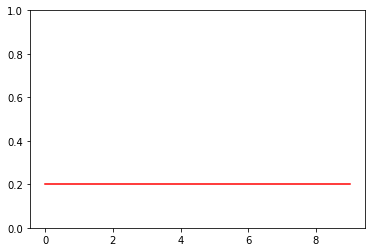

KeyboardInterrupt: 

In [6]:
init_weights(model, 0)


start_e = len(loss_trace) + 1
for e in range(start_e, num_epochs):
    model.train()
    loss_sum = 0
    for mix, tar in tqdm_notebook(train_iter):
        mix = mix.to(device)
        tar = tar.to(device)
        y_hat = model(mix)
        loss = criterion(y_hat, tar)
        loss.backward()
        optim.step()
        optim.zero_grad()
        loss_sum += loss.item() * mix.shape[0]
    
    scheduler.step()
    
    ipd.clear_output(wait=True)
    print('epoch' , e)

    epoch_avg_loss = loss_sum / len(train_set)
    loss_trace.append(epoch_avg_loss)
    print(epoch_avg_loss)
    plt.plot(loss_trace, 'b', [0.2 for _ in range(e)], 'r')
    plt.ylim(0, 1.0)
    plt.show()
    
    torch.save(optim.state_dict(), '{0}/{1}/{2}_optim.pt'.format(model_path, model_name, target_name))
    torch.save(scheduler.state_dict(), '{0}/{1}/{2}_sched.pt'.format(model_path, model_name, target_name))
    torch.save(model.state_dict(), '{0}/{1}/{2}.pt'.format(model_path, model_name, target_name))
    np.save('{0}/{1}/{2}_loss.npy'.format(model_path, model_name, target_name), loss_trace)
    if e>=ckpt_min_epoch and e%ckpt_steps==0:
        torch.save(model.state_dict(), '{0}/{1}/{2}{3:05}.pt'.format(model_path, model_name, target_name, e))
    

### Visualize tensors

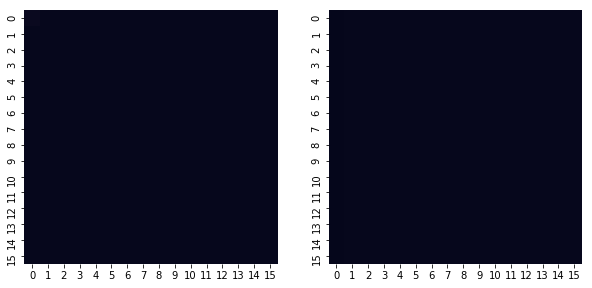

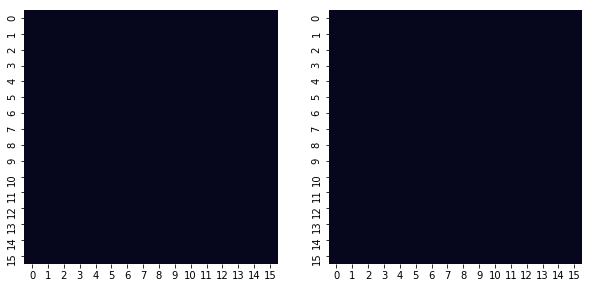

In [9]:
import seaborn

for att_layer in model.att.att_layers:
    fig, axs = plt.subplots(1, hp.num_heads, figsize=(10, 5))
    att = att_layer[-1].att[0][0].detach().cpu().numpy()

    for h in range(hp.num_heads):
        seaborn.heatmap(att[h], square=True, vmin=0.0, vmax=5.0, cbar=False, ax=axs[h])
    plt.show()


## Validation

In [6]:
def preprocess_track(y):
    n_sample = y.shape[1]
    
    gen_size = sampling_size-2*trim
    pad = gen_size - n_sample%gen_size
    y_p = np.concatenate((np.zeros((2,trim)), y, np.zeros((2,pad)), np.zeros((2,trim))), 1)
    
    mag, phase = [], []
    i = 0
    while i < n_sample + pad:
        specs = to_specs(y_p[:, i:i+sampling_size])
        mag.append(specs[0])
        phase.append(specs[1])
        i += gen_size

    return torch.tensor(mag), np.array(phase), pad


def separate(model, mix):
    model.eval()
    
    mix_mag, mix_phase, pad_len = preprocess_track(mix)
    
    batch_size = 8 
    i = 0
    num_intervals = mix_mag.shape[0]
    batches = []
    while i < num_intervals:
        batches.append(mix_mag[i:i+batch_size])
        i = i + batch_size

    tar_signal = np.array([[],[]])
    with torch.no_grad():
        i = 0
        for batch in tqdm_notebook(batches):
            tar_mags = model(batch.to(device))
            for tar_mag in tar_mags:
                est_interval = np.array(restore(tar_mag.detach().cpu().numpy(), mix_phase[i]))[:, trim:-trim]
                tar_signal = np.concatenate((tar_signal, est_interval), 1)
                i += 1
            
    return tar_signal[:, :-pad_len]

In [7]:
def mean_nan(a):
    return a[~np.isnan(a)].mean()

def median_nan(a):
    return np.median(a[~np.isnan(a)])


def dsd_sdr(ref, est, framewise=True):
    if framewise:
        sdr, isr, sir, sar, perm = eval3.bss_eval_images_framewise(ref, est)
    else:
        sdr, isr, sir, sar, perm = eval3.bss_eval_images(ref, est)
    return mean_nan(sdr[0])


def musdb_sdr(ref, est, sr=sampling_rate):
    sdr, isr, sir, sar, perm = eval4.metrics.bss_eval(ref, est, window=sr, hop=sr)
    return median_nan(sdr[0])

4.0969616983823745 / 6.188952671878107


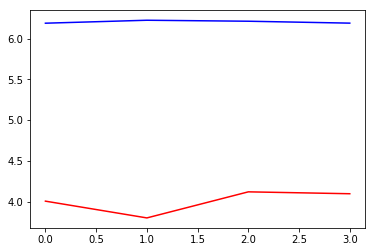

0.8412525876612514


6.291697235095288


KeyboardInterrupt: 

In [8]:
ckpt_max_epoch = 32000
ckpt_min_epoch = 30000
num_ckpts = (ckpt_max_epoch - ckpt_min_epoch) // ckpt_steps + 1

scores_mean = []
scores_median = []

# scores = np.load('{0}/{1}/{2}_valid.npy'.format(model_path, model_name, target_name))
# scores_mean, scores_median = list(scores[0]), list(scores[1])

for c in range(num_ckpts):
    ckpt_scores = []
    init_weights(model, 1, epoch=ckpt_min_epoch + c*ckpt_steps)
    for i in tqdm_notebook(range(14)):
        est = separate(model, load('{0}/{1}/{2:02}.wav'.format(musdb_valid_path, mix_name, i)))
        ref = load('{0}/{1}/{2:02}.wav'.format(musdb_valid_path, target_name, i))
    
        sdr = musdb_sdr(np.array([ref.T]), np.array([est.T]))
        print(sdr)
        
        ckpt_scores.append(sdr)
    
    sleep(1)
    ckpt_score_mean = np.array(ckpt_scores).mean()
    ckpt_score_median = np.median(np.array(ckpt_scores))
    scores_mean.append(ckpt_score_mean)
    scores_median.append(ckpt_score_median)
    
    ipd.clear_output(wait=True)
    print(ckpt_score_mean, '/', ckpt_score_median)
    plt.plot(scores_mean, 'r', scores_median, 'b')
    plt.show()
    
np.save('{0}/{1}/{2}_valid.npy'.format(model_path, model_name, target_name), np.array([scores_mean, scores_median]))

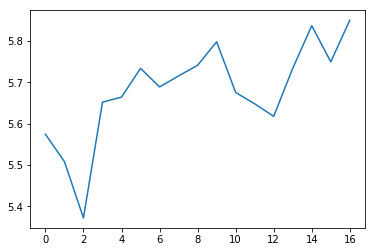

In [13]:
scores = np.load('{0}/{1}/{2}_valid.npy'.format(model_path, model_name, target_name))
scores_mean, scores_median = list(scores[0]), list(scores[1])

plt.plot(scores_median)

## Generate

In [ ]:
init_weights(model, 1, epoch=10000)

for i in tqdm_notebook(range(50)):
    track_name = 'test_{0:02}'.format(i)   
    tar_signal = separate(model, load('{0}{1}/{2:02}.wav'.format(musdb_test_path, mix_name, i)))
    
    t_path = '{0}/{1}/estimates_sources/{2}/{3}.wav'.format(model_path, model_name, track_name, target_name)
    librosa.output.write_wav(t_path, np.array(tar_signal, np.float32), sampling_rate)

## Evaluation

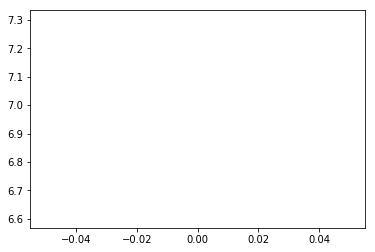

SDR mean: 6.951005132655721
SDR median: 6.951005132655721


KeyboardInterrupt: 

In [15]:
import math
import statistics as stats

SDR = []
for i in range(50):
    
    ref = load('{0}/{1}/{2:02}.wav'.format(musdb_test_path, target_name, i))
    est = load('{0}/{1}/estimates_sources/test_{2:02}/{3}.wav'.format(model_path, model_name, i, target_name))
    sdr = musdb_sdr(np.array([ref.T]), np.array([est.T]))
    
    print(sdr)
    SDR.append(sdr)

    
    ipd.clear_output(wait=True)
    plt.plot(SDR)
    plt.show()

    print('SDR mean:', stats.mean(SDR))
    print('SDR median:', stats.median(SDR))


### Create Folders

In [19]:
os.mkdir('{0}/{1}'.format(model_path, model_name))

os.mkdir('{0}/{1}/estimates_sources'.format(model_path, model_name))
for i in tqdm_notebook(range(50)):
    track_name = 'test_{0:02}'.format(i)
    p = '{0}/{1}/estimates_sources/test_{2:02}'.format(model_path, model_name, i)
    os.mkdir(p)

### Preprocess DSD100

In [ ]:
t_names = ['vocals', 'drums', 'bass', 'other']

p = 'data/DSD100/Train'
name_list = sorted(os.listdir(p + '/Mixtures'))

valid_indices = [53,55,65,68,69]
#name_list = [name_list[v-51] for v in valid_indices]
name_list = [name for i, name in enumerate(name_list) if i+51 not in valid_indices]

save_path = dsd_train_path

for i, name in enumerate(name_list):
    m = load('{0}/Mixtures/{1}/mixture.wav'.format(p, name))
    librosa.output.write_wav('{0}{1}/{2:02}.wav'.format(save_path, mix_name, i), np.array(m, np.float32), sampling_rate)

    for t_name in t_names:
        t = load('{0}/Sources/{1}/{2}.wav'.format(p, name, t_name))
        librosa.output.write_wav('{0}{1}/{2:02}.wav'.format(save_path, t_name, i), np.array(t, np.float32), sampling_rate)


### Preprocess Musdb2018

In [8]:
import musdb

p = 'data/musdb18'

musdb_train = musdb.DB(root=p, subsets='train', split='train')
musdb_valid = musdb.DB(root=p, subsets='train', split='valid')
musdb_test = musdb.DB(root=p, subsets='test')

In [6]:
t_names = ['vocals', 'drums', 'bass', 'other']

save_path = musdb_test_path

for i, track in tqdm_notebook(list(enumerate(musdb_test))):
    m = np.array(track.audio.T, np.float32)
    librosa.output.write_wav('{0}{1}/{2:02}.wav'.format(save_path, mix_name, i), m, sampling_rate)

    for t_name in t_names:
        t = np.array(track.sources[t_name].audio.T, np.float32)
        librosa.output.write_wav('{0}{1}/{2:02}.wav'.format(save_path, t_name, i), t, sampling_rate)

    

In [ ]:
lengths = []
for i in tqdm_notebook(range(86)):
    p = '{0}{1}/{2:02}'.format(musdb_train_path, mix_name, i)
    a = load(p+'.wav')
    lengths.append(a.shape[-1])
np.save(musdb_train_path+'lengths.npy', np.array(lengths))